<a href="https://colab.research.google.com/github/akhiilkasare/NYC-Taxi-Fare-Price-Prediction-Using-PyTorch/blob/main/NYC_Taxi_Fares_Prediction_Using_Pytorch_Regression_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/nyc-taxi-fare-price-pytorch/NYCTaxiFares.csv')

In [ ]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [ ]:
df.describe()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,10.040326,0.333333,-73.976626,40.751443,-73.974501,40.751695,1.347167
std,7.500134,0.471406,0.031497,0.025821,0.032419,0.030279,0.759263
min,2.500000,0.000000,-74.465447,40.121653,-74.443323,40.164927,1.000000
25%,5.700000,0.000000,-73.992386,40.736594,-73.991478,40.735914,1.000000
50%,7.700000,0.000000,-73.982084,40.753661,-73.980411,40.754441,1.000000
75%,11.300000,1.000000,-73.968710,40.768020,-73.965500,40.768880,1.000000
max,49.900000,1.000000,-73.311845,40.981292,-73.496140,40.993498,5.000000


### Converting the latitude and longitude in kms using havershine distance formula

In [ ]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])  # converting the longitude and latidtude into numpy radians
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [ ]:
df['distance_km'] = haversine_distance(df, 'pickup_latitude', 'pickup_longitude','dropoff_latitude','dropoff_longitude')

In [ ]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance_km'],
      dtype='object')

In [ ]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
 8   distance_km        120000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


### Converting the pickup_datetime object column into date_time column

In [ ]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   distance_km        120000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [ ]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [ ]:
## Adjusting 4 hours difference than the actual time

df['edtdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

In [ ]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,edtdate
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00


In [ ]:
df['Hour'] = df['edtdate'].dt.hour

In [ ]:
df['am_or_pm'] = np.where(df['Hour']<12, 'am', 'pm')

In [ ]:
df['weekday'] = df['edtdate'].dt.strftime("%a")

In [ ]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,edtdate,Hour,am_or_pm,weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


In [ ]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance_km', 'edtdate', 'Hour', 'am_or_pm',
       'weekday'],
      dtype='object')

In [ ]:
cat_cols = ['Hour', 'am_or_pm', 'weekday']
cont_cols = ['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance_km']

In [ ]:
y_col = ['fare_amount']

In [ ]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [ ]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
distance_km                      float64
edtdate              datetime64[ns, UTC]
Hour                            category
am_or_pm                        category
weekday                         category
dtype: object

In [ ]:
df.Hour.head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [ ]:
hr = df['Hour'].cat.codes.values
am_pm = df['am_or_pm'].cat.codes.values
wkdy = df['weekday'].cat.codes.values

In [ ]:
hr

array([ 4, 11,  7, ..., 14,  4, 12], dtype=int8)

In [ ]:
cats = np.stack([hr,am_pm,wkdy], axis=1)
cats

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

In [ ]:
# cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)

In [ ]:
cats = torch.tensor(cats, dtype=torch.int64)

In [ ]:
### Stacking the continous columns

conts = np.stack([df[col].values for col in cont_cols], axis=1)

In [ ]:
conts

array([[-73.992365  ,  40.730521  , -73.975499  ,  40.744746  ,
          1.        ,   2.12631159],
       [-73.990078  ,  40.740558  , -73.974232  ,  40.744114  ,
          1.        ,   1.39230687],
       [-73.994149  ,  40.751118  , -73.960064  ,  40.766235  ,
          2.        ,   3.32676344],
       ...,
       [-73.988574  ,  40.749772  , -74.011541  ,  40.707799  ,
          3.        ,   5.05252282],
       [-74.004449  ,  40.724529  , -73.992697  ,  40.730765  ,
          1.        ,   1.20892296],
       [-73.955415  ,  40.77192   , -73.967623  ,  40.763015  ,
          3.        ,   1.42739869]])

In [ ]:
### Converting it into tensors

conts = torch.tensor(conts, dtype=torch.float)
conts

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.4274]])

In [ ]:
### Converting the label column into tensor

y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

In [ ]:
conts.shape

torch.Size([120000, 6])

In [ ]:
y.shape

torch.Size([120000, 1])

In [ ]:
### Defining embedding sizes

cat_sizes = [len(df[col].cat.categories) for col in cat_cols]
cat_sizes

[24, 2, 7]

* 24 - 24 hours in a day
* 2 - am or pm
* 7 - 7 days a week

In [ ]:
emb_sizes = [(size, min(50,(size+1)//2)) for size in cat_sizes]
emb_sizes

[(24, 12), (2, 1), (7, 4)]

In [ ]:
### Creating the embedding layer

selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_sizes])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [ ]:
class TabularModel(nn.Module):
    
    def __init__(self, emb_sizes, n_cont, out_szs, layers, p=0.5):
        super().__init__()
        
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_sizes])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layer_list = []
        n_emb = sum([nf for ni,nf in emb_sizes])
        n_in = n_emb + n_cont
        
        for i in layers:
            layer_list.append(nn.Linear(n_in, i))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(i))
            layer_list.append(nn.Dropout(p))
            n_in = i
            
        layer_list.append(nn.Linear(layers[-1], out_szs))
        
        self.layers = nn.Sequential(*layer_list)
        
    def forward(self, x_cat, x_cont):
        embeddings = []
        
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
            
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x,x_cont], 1)
        x = self.layers(x)
        
        return x
        
        

In [ ]:
torch.manual_seed(33)
model = TabularModel(emb_sizes, conts.shape[1], 1,[200,100], p=0.4)

In [ ]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
batch_size=60000
test_size = int(batch_size*0.2)

In [ ]:
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]

In [ ]:
y_train=y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [ ]:
len(cat_train)

48000

In [ ]:
len(con_train)

48000

In [ ]:
import time

start_time = time.time()

final_losses = []

for epochs in range(1000):
    optimizer.zero_grad()
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    final_losses.append(loss)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epochs+1}, loss: {loss.item()}")
    
duration = time.time() - start_time
print(f"Training took {duration/60} minutes")

Epoch 1, loss: 12.586901664733887
Epoch 2, loss: 11.779983520507812
Epoch 3, loss: 11.313923835754395
Epoch 4, loss: 10.983816146850586
Epoch 5, loss: 10.703396797180176
Epoch 6, loss: 10.475826263427734
Epoch 7, loss: 10.292169570922852
Epoch 8, loss: 10.125777244567871
Epoch 9, loss: 9.995330810546875
Epoch 10, loss: 9.870637893676758
Epoch 11, loss: 9.732337951660156
Epoch 12, loss: 9.59315013885498
Epoch 13, loss: 9.451120376586914
Epoch 14, loss: 9.301545143127441
Epoch 15, loss: 9.142586708068848
Epoch 16, loss: 8.982436180114746
Epoch 17, loss: 8.803691864013672
Epoch 18, loss: 8.60965633392334
Epoch 19, loss: 8.390485763549805
Epoch 20, loss: 8.155844688415527
Epoch 21, loss: 7.924241542816162
Epoch 22, loss: 7.657634735107422
Epoch 23, loss: 7.380258083343506
Epoch 24, loss: 7.088366508483887
Epoch 25, loss: 6.781723499298096
Epoch 26, loss: 6.444967269897461
Epoch 27, loss: 6.107254981994629
Epoch 28, loss: 5.75056266784668
Epoch 29, loss: 5.407918453216553
Epoch 30, loss: 5.

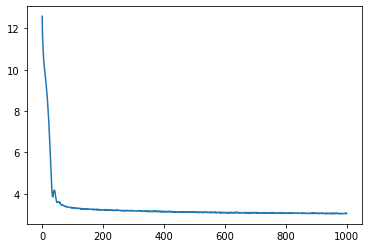

In [ ]:
### PLotting the loss function

plt.plot(range(1000), final_losses)

In [ ]:
### Evaluating our model on the test set

with torch.no_grad():
    
    y_val = model(cat_test, con_test)
    
    loss = torch.sqrt(criterion(y_val, y_test))

In [ ]:
for i in range(20):
    
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'PREDICTED VALUES : {y_val[i].item():8.4f} TRUE VALUES : {y_test[i].item():8.2f} DIFF : {diff:8.2f}')

PREDICTED VALUES :   4.0635 TRUE VALUES :     2.90 DIFF :     1.16
PREDICTED VALUES :  24.2182 TRUE VALUES :     5.70 DIFF :    18.52
PREDICTED VALUES :   5.3872 TRUE VALUES :     7.70 DIFF :     2.31
PREDICTED VALUES :  11.5688 TRUE VALUES :    12.50 DIFF :     0.93
PREDICTED VALUES :   4.0781 TRUE VALUES :     4.10 DIFF :     0.02
PREDICTED VALUES :   4.7976 TRUE VALUES :     5.30 DIFF :     0.50
PREDICTED VALUES :   2.6458 TRUE VALUES :     3.70 DIFF :     1.05
PREDICTED VALUES :  19.5448 TRUE VALUES :    14.50 DIFF :     5.04
PREDICTED VALUES :   5.7740 TRUE VALUES :     5.70 DIFF :     0.07
PREDICTED VALUES :  12.2214 TRUE VALUES :    10.10 DIFF :     2.12
PREDICTED VALUES :   4.3655 TRUE VALUES :     4.50 DIFF :     0.13
PREDICTED VALUES :   5.5553 TRUE VALUES :     6.10 DIFF :     0.54
PREDICTED VALUES :   8.2402 TRUE VALUES :     6.90 DIFF :     1.34
PREDICTED VALUES :  13.3195 TRUE VALUES :    14.10 DIFF :     0.78
PREDICTED VALUES :   5.8202 TRUE VALUES :     4.50 DIFF :     